In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import geopandas as gpd
import datetime

import numpy as np
import os

In [3]:
directory = 'adsb_delft/csv'

files = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        files.append(f)
        
files.sort()

In [4]:
print(files[0])

adsb_delft/csv/adsb_decoded_20170101.csv


In [5]:
date = 20170101

df = pd.read_csv('adsb_delft/csv/adsb_decoded_{}.csv'.format(date))
df.dropna(subset=["callsign"], inplace=True)

In [6]:
df_grouped = df.groupby('icao', group_keys=True).apply(lambda x: x)
df_grouped['updateinterval'] = df_grouped['ts'].diff()
df_grouped = df_grouped[(df_grouped['updateinterval'] > 0) & (df_grouped['updateinterval'] < 50)]
ungrouped_df = df_grouped.reset_index(drop=True)

In [7]:
def categorize_update_interval(all_update_interval):
    result_dict = {}

    for num in all_update_interval:
        rounded_value = round(num, 1)
        if rounded_value not in result_dict:
            result_dict[rounded_value] = 0
        result_dict[rounded_value] += 1

    result_dict = dict(sorted(result_dict.items()))

    return result_dict

In [8]:
all_update_interval = ungrouped_df['updateinterval'].tolist()
update_interval_dict = categorize_update_interval(all_update_interval)

Text(0.5, 1.0, 'Date: 20170101 \n  Update Interval Distribution')

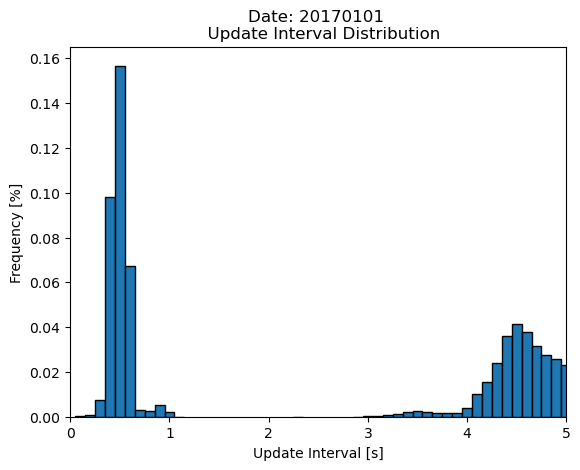

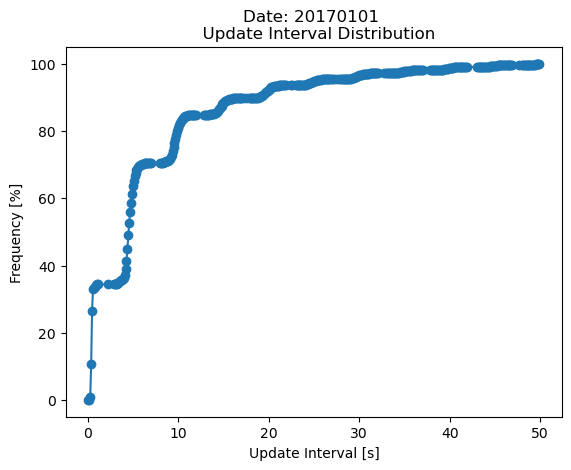

In [9]:
cum_freq = []
cum_freq_one = 0

for key in update_interval_dict.keys():
    cum_freq_one += update_interval_dict[key]
    cum_freq.append(cum_freq_one)
        
x_values = list(update_interval_dict.keys())
y_values = list(update_interval_dict.values())
y_values_total = sum(y_values)
y_values = np.array(y_values)/y_values_total
cum_freq = np.array(cum_freq)/y_values_total*100

plt.figure(1)
plt.clf()
plt.bar(x_values, y_values, width=0.1, edgecolor='black')
# Add labels and title
plt.xlabel('Update Interval [s]')
plt.ylabel('Frequency [%]')
plt.title('Date: {} \n  Update Interval Distribution'.format(date))
# plt.savefig('scrap_results/images/freq_{}.png'.format(serial))
plt.axis([0, 5, 0, 0.165])

plt.figure(2)
plt.clf()
plt.plot(x_values, cum_freq, '-o')
# Add labels and title
plt.xlabel('Update Interval [s]')
plt.ylabel('Frequency [%]')
plt.title('Date: {} \n  Update Interval Distribution'.format(date))
# plt.savefig('scrap_results/images/freq_{}.png'.format(serial))

In [10]:
df.dropna(subset=["spd"], inplace=True)

## New Analysis

In [11]:
df = pd.read_csv('adsb_delft/csv/adsb_decoded_{}.csv'.format(date))
df.dropna(subset=["callsign"], inplace=True)
df

,ts,icao,lat,lon,alt,spd,hdg,roc,callsign
3,1.483225e+09,406D94,53.26353,0.32280,35975,NaN,NaN,NaN,EZY49YZ_
6,1.483225e+09,48520B,51.37291,3.50060,27800,484.0,28.7,-3968.0,TRA667M_
9,1.483225e+09,44A833,50.11158,2.85578,27875,435.0,43.1,-1024.0,JAF1HD__
14,1.483225e+09,01010D,51.19922,1.27289,27025,472.0,96.4,1408.0,MSR780__
16,1.483225e+09,4BAA85,50.63855,3.90629,34950,452.0,109.5,0.0,THY9SU__
...,...,...,...,...,...,...,...,...,...
6001075,1.483312e+09,4CA9EA,50.92987,7.45079,38000,NaN,NaN,NaN,RYR31WJ_
6001078,1.483312e+09,424556,51.97101,1.76147,27475,507.0,71.9,1408.0,AFL2585_
6001080,1.483312e+09,4CA979,51.92015,2.92328,25900,292.0,268.4,-1024.0,RYR22AE_
6001118,1.483312e+09,471F64,50.92889,3.35220,35000,481.0,100.5,0.0,WZZ3FJ__


In [12]:
interval = 10 #min
duration = 12
duration *= 60

ts_start = df['ts'].iloc[0]
ts_end = ts_start + interval*60

visible_ac = []
mean_of_update_interval = []
time = []
all_update_interval = []

nb_data = int(duration/interval)

for i in range(nb_data):
    df_one_min = df[(df['ts'] >= ts_start) & (df['ts'] < ts_end)]
    dt = datetime.datetime.fromtimestamp(df_one_min['ts'].iloc[-1])
#     print(dt)
    
    df_grouped = df_one_min.groupby('icao', group_keys=True).apply(lambda x: x)
    df_grouped['updateinterval'] = df_grouped['ts'].diff()
    df_grouped = df_grouped[(df_grouped['updateinterval'] > 0) & (df_grouped['updateinterval'] < 50)]
    ungrouped_df = df_grouped.reset_index(drop=True)
    
    visible_ac.append(len(df_one_min['icao'].unique()))
    mean_of_update_interval.append(ungrouped_df['updateinterval'].mean())
    time.append(ts_start)
        
    all_update_interval.extend(ungrouped_df['updateinterval'])
    
    ts_start = ts_end
    ts_end = ts_start + interval*60
    

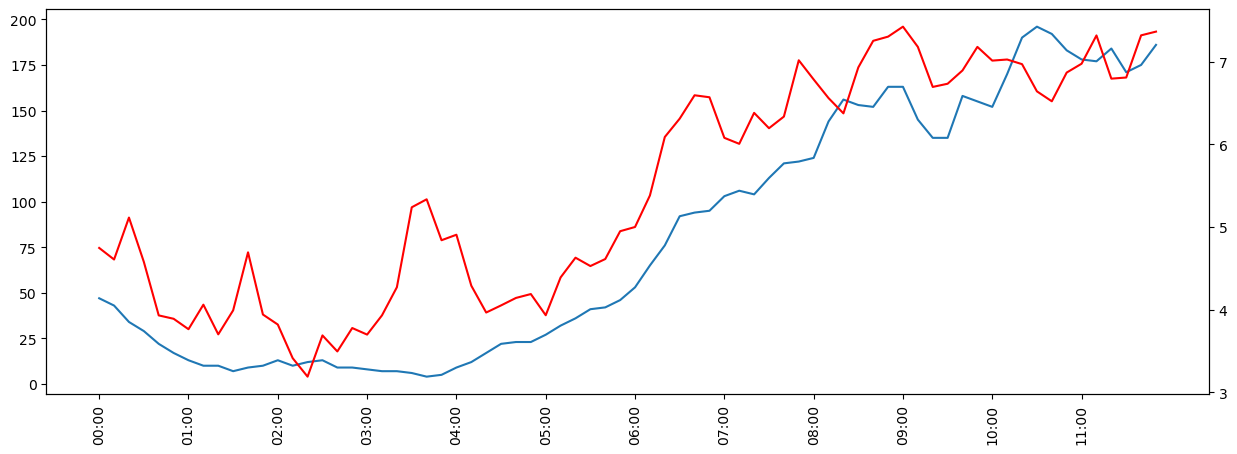

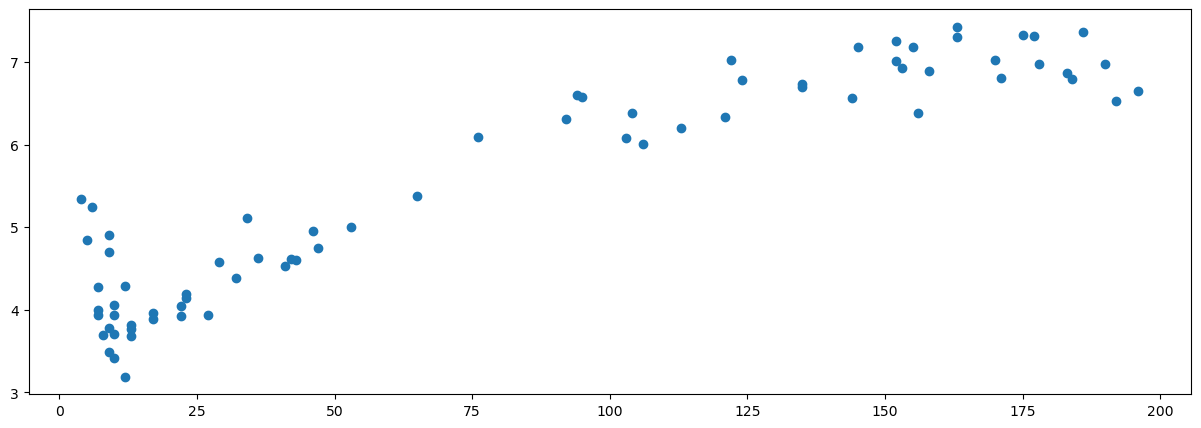

In [13]:
time_normal = []

for t in time:
    hour = datetime.datetime.fromtimestamp(t).hour
    minute = datetime.datetime.fromtimestamp(t).minute
    time_normal.append("{:02d}:{:02d}".format(hour, minute))

# plt.figure(1)
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(time, visible_ac)
ax1.set_xticks(time[::6])
ax1.set_xticklabels(time_normal[::6], rotation=90)

ax2=ax1.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(time, mean_of_update_interval, 'r')

# ax2.set_ylabel("gdpPercap",color="blue",fontsize=14)
# plt.show()
# # save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,
#             bbox_inches='tight')

fig, ax3 = plt.subplots(figsize=(15, 5))
ax3.scatter(visible_ac, mean_of_update_interval)

In [14]:
ungrouped_df[ungrouped_df["updateinterval"] > 10]

,ts,icao,lat,lon,alt,spd,hdg,roc,callsign,updateinterval
3,1.483268e+09,020119,50.13757,3.44508,33250,422.0,208.1,1024.0,MAC122__,10.4
4,1.483268e+09,020119,49.70476,3.09020,35000,NaN,NaN,NaN,MAC122__,39.6
8,1.483268e+09,06A001,51.14699,1.07889,22125,439.0,90.8,2304.0,A7HHK___,24.8
10,1.483268e+09,06A001,51.14634,1.14510,22950,NaN,NaN,NaN,A7HHK___,20.2
11,1.483268e+09,06A001,51.14561,1.20671,23500,NaN,NaN,NaN,A7HHK___,19.3
...,...,...,...,...,...,...,...,...,...,...
4842,1.483268e+09,E4818C,49.12436,3.80873,36000,508.0,72.4,0.0,TAM8070_,10.1
4844,1.483268e+09,E4818C,49.31023,4.63789,36000,NaN,NaN,NaN,TAM8070_,45.0
4845,1.483268e+09,E4818C,49.32431,4.68898,36000,510.0,67.1,0.0,TAM8070_,15.2
4846,1.483268e+09,E4818C,49.34271,4.75525,36000,NaN,NaN,NaN,TAM8070_,20.1


In [15]:
t = ungrouped_df['ts'][0]

hour = datetime.datetime.fromtimestamp(t).hour
minute = datetime.datetime.fromtimestamp(t).minute
print(hour, minute)

11 50


In [16]:
def nautical_miles_to_latitude_degrees(nm):
    # Earth's radius in nautical miles
    earth_radius_nm = 3440.069

    # Convert 5 nautical miles to latitude degrees using the Haversine formula
    latitude_degrees = nm / earth_radius_nm * 180 / math.pi

    return latitude_degrees

def nautical_miles_to_longitude_degrees(nm, latitude):
    # Earth's radius in nautical miles
    earth_radius_nm = 3440.069

    # Convert 5 nautical miles to longitude degrees using the Haversine formula
    longitude_degrees = nm / (earth_radius_nm * math.cos(latitude * math.pi / 180)) * 180 / math.pi

    return longitude_degrees

0.99004802208


Text(0, 0.5, 'Lat [deg]')

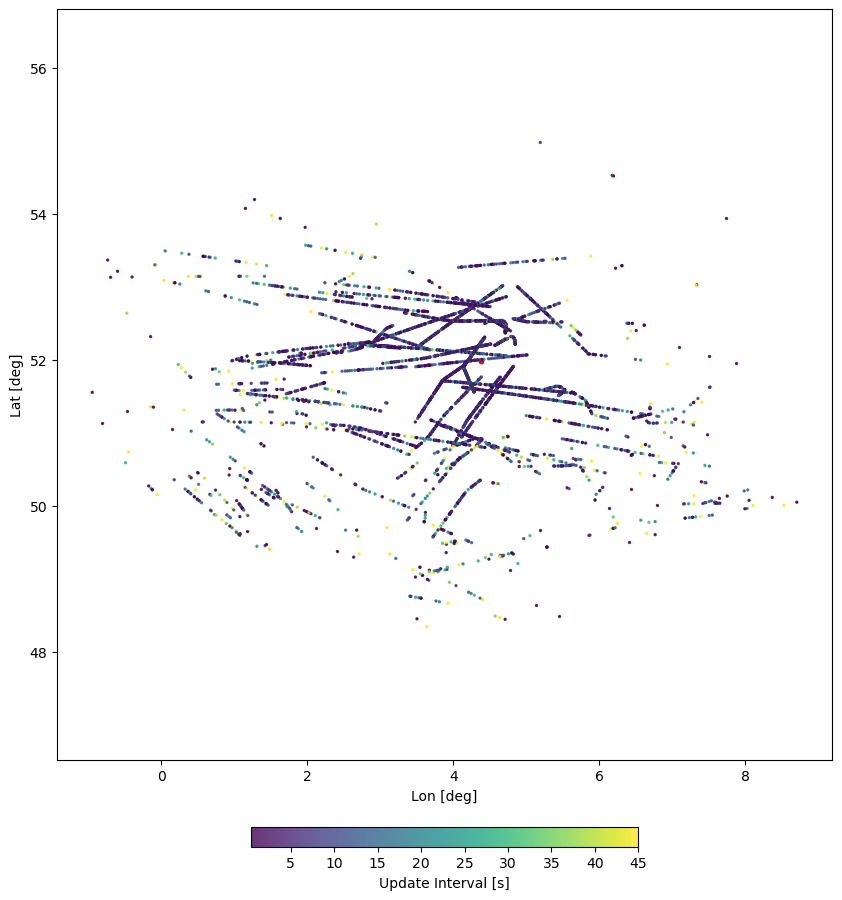

In [17]:
icao = ungrouped_df["icao"].unique().tolist()

plt.subplots(figsize=(10, 12.5))

lat_tu_delft = 51.990122
lon_tu_delft = 4.375662

plt.scatter(lon_tu_delft, lat_tu_delft, s = 10, color = 'r')
# plt.text(lon_tu_delft, lat_tu_delft, "LR Delft")

v = 230.278
lookahead_time = 300
dist = v*lookahead_time/1000

km_to_lon = 0.0143312
print(dist*km_to_lon)

circle1 = Circle((lon_tu_delft, lat_tu_delft), 0.096, edgecolor='red', facecolor='none', linewidth=2, alpha = 0.5)
circle2 = Circle((lon_tu_delft, lat_tu_delft), 0.99, edgecolor='black', facecolor='none', linewidth=2, alpha = 0.5)

# plt.gca().add_patch(circle1)
# plt.gca().add_patch(circle2)
# plt.legend(["LR TU Delft", "5 NM", "5 NM with 5 mins lookahead"])

plt.axis('equal')

for ic in icao:
    ac1 = ungrouped_df[ungrouped_df["icao"] == ic]
    lon_data = ac1['lon'].tolist()
    lat_data = ac1['lat'].tolist()
    up_data = ac1['updateinterval'].tolist()
    
    scatter = plt.scatter(lon_data, lat_data, c=up_data, cmap='viridis', s=2, alpha=0.8)

cbar = plt.colorbar(scatter, label='Update Interval [s]', orientation = "horizontal", pad = 0.07, shrink = 0.5)
plt.xlabel("Lon [deg]")
plt.ylabel("Lat [deg]")

In [26]:
countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

/var/folders/gt/7bzbbv711312cfd_13h4fkm5z8xgxd/T/ipykernel_63127/1771207407.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gpd.datasets.get_path("naturalearth_lowres"))


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


0.99004802208


(-1.0, 9.0, 47.0, 57.0)

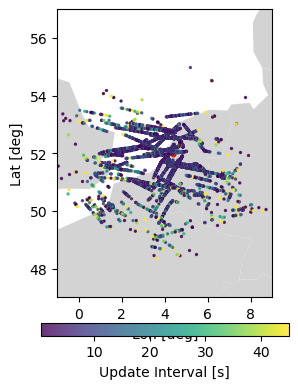

In [32]:
countries[countries["continent"] == "Europe"].plot(color="lightgrey")

lat_tu_delft = 51.990122
lon_tu_delft = 4.375662

plt.scatter(lon_tu_delft, lat_tu_delft, s = 10, color = 'r')
# plt.text(lon_tu_delft, lat_tu_delft, "LR Delft")

v = 230.278
lookahead_time = 300
dist = v*lookahead_time/1000

km_to_lon = 0.0143312
print(dist*km_to_lon)

circle1 = Circle((lon_tu_delft, lat_tu_delft), 0.096, edgecolor='red', facecolor='none', linewidth=2, alpha = 0.5)
circle2 = Circle((lon_tu_delft, lat_tu_delft), 0.99, edgecolor='black', facecolor='none', linewidth=2, alpha = 0.5)

# plt.gca().add_patch(circle1)
# plt.gca().add_patch(circle2)
# plt.legend(["LR TU Delft", "5 NM", "5 NM with 5 mins lookahead"])

for ic in icao:
    ac1 = ungrouped_df[ungrouped_df["icao"] == ic]
    lon_data = ac1['lon'].tolist()
    lat_data = ac1['lat'].tolist()
    up_data = ac1['updateinterval'].tolist()
    
    scatter = plt.scatter(lon_data, lat_data, c=up_data, cmap='viridis', s=2, alpha=0.8)

cbar = plt.colorbar(scatter, label='Update Interval [s]', orientation = "horizontal", pad = 0.07, shrink = 0.5)
plt.xlabel("Lon [deg]")
plt.ylabel("Lat [deg]")

plt.axis([-1, 9, 47, 57])
# plt.axis('equal')

Text(0.5, 1.0, 'Date: 20170101 \n  Update Interval Distribution')

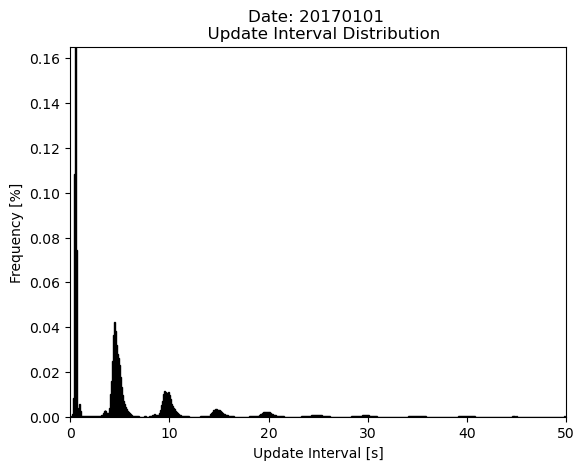

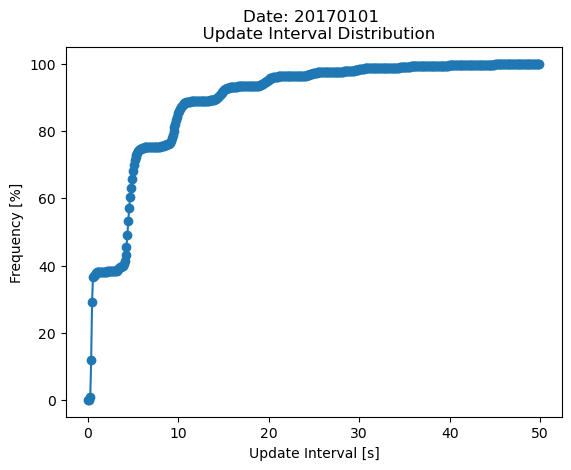

In [128]:
update_interval_dict = categorize_update_interval(all_update_interval)

cum_freq = []
cum_freq_one = 0

for key in update_interval_dict.keys():
    cum_freq_one += update_interval_dict[key]
    cum_freq.append(cum_freq_one)
        
x_values = list(update_interval_dict.keys())
y_values = list(update_interval_dict.values())
y_values_total = sum(y_values)
y_values = np.array(y_values)/y_values_total
cum_freq = np.array(cum_freq)/y_values_total*100

plt.figure(1)
plt.clf()
plt.bar(x_values, y_values, width=0.1, edgecolor='black')
# Add labels and title
plt.xlabel('Update Interval [s]')
plt.ylabel('Frequency [%]')
plt.title('Date: {} \n  Update Interval Distribution'.format(date))
# plt.savefig('scrap_results/images/freq_{}.png'.format(serial))
plt.axis([0, 50, 0, 0.165])

plt.figure(2)
plt.clf()
plt.plot(x_values, cum_freq, '-o')
# Add labels and title
plt.xlabel('Update Interval [s]')
plt.ylabel('Frequency [%]')
plt.title('Date: {} \n  Update Interval Distribution'.format(date))
# plt.savefig('scrap_results/images/freq_{}.png'.format(serial))

In [65]:
df.dropna(subset=["callsign"], inplace=True)
df.dropna(subset=["spd"], inplace=True)

In [57]:
df_grouped = df.groupby('icao', group_keys=True).apply(lambda x: x)
df_grouped['updateinterval'] = df_grouped['ts'].diff()
df_grouped = df_grouped[(df_grouped['updateinterval'] > 0) & (df_grouped['updateinterval'] < 50)]
ungrouped_df = df_grouped.reset_index(drop=True)

In [60]:
all_update_interval = ungrouped_df['updateinterval'].tolist()
update_interval_dict = categorize_update_interval(all_update_interval)
# print(update_interval_dict)

Text(0.5, 1.0, 'Date: 20170101 \n  Update Interval Distribution')

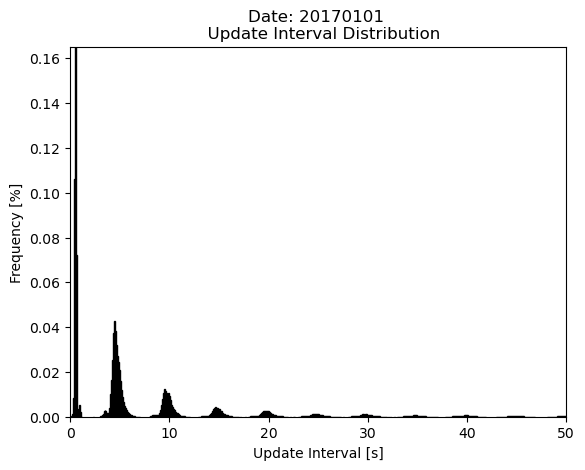

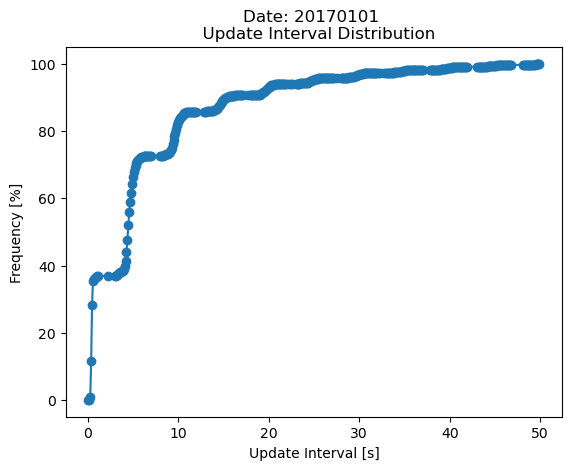

In [62]:
cum_freq = []
cum_freq_one = 0

for key in update_interval_dict.keys():
    cum_freq_one += update_interval_dict[key]
    cum_freq.append(cum_freq_one)
        
x_values = list(update_interval_dict.keys())
y_values = list(update_interval_dict.values())
y_values_total = sum(y_values)
y_values = np.array(y_values)/y_values_total
cum_freq = np.array(cum_freq)/y_values_total*100

plt.figure(1)
plt.clf()
plt.bar(x_values, y_values, width=0.1, edgecolor='black')
# Add labels and title
plt.xlabel('Update Interval [s]')
plt.ylabel('Frequency [%]')
plt.title('Date: {} \n  Update Interval Distribution'.format(date))
# plt.savefig('scrap_results/images/freq_{}.png'.format(serial))
plt.axis([0, 50, 0, 0.165])

plt.figure(2)
plt.clf()
plt.plot(x_values, cum_freq, '-o')
# Add labels and title
plt.xlabel('Update Interval [s]')
plt.ylabel('Frequency [%]')
plt.title('Date: {} \n  Update Interval Distribution'.format(date))
# plt.savefig('scrap_results/images/freq_{}.png'.format(serial))

In [88]:
import datetime

df['ts'][0]

dt = datetime.datetime.fromtimestamp(df['ts'][0])
dt

datetime.datetime(2017, 1, 1, 0, 0, 0, 400000)